In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from numba import njit

@njit
def sc_jit(ref, seq):
    n = len(ref) - len(seq) + 1
    cv = np.zeros(n, dtype=np.int8) 
    for i in range(n):
        count = 0
        for j in range(len(seq)):
            if ref[i + j] == seq[j]:
                count += 1
        cv[i] = count
    return cv
sc_jit(np.random.randint(0, 3, 100), np.random.randint(0, 3, 10));    # call it once for numba to compile the function

## RNA-RNA binding - Boltzman probabilities from hydrogen bond energies

statistical mechanics / thermodynamics allow us to predict binding probabilities from the interation energies. 
using bond energy per hydrogen bond ~ 1kT we can estimate that an AT pair carries 2kT and a GC pair 3kT of energy, while missmatches are assumed to have 0kT. The total binding energy is then just the sum of all matching base pairs. 
The Boltzmanfactor allows us to compare the binding probabilities (related to the association and dissociation rate) for different number of missmatches.

In [2]:
def encoder(seq):
    '''map sequence values into new axis to encode interaction strengths'''
    array = np.zeros((len(seq),4))
    for i in range(len(array)):
        array[i, seq[i]] = np.sqrt((2+(seq[i]>1))) # allows us to define different interaction energies [kT]
    return array

def sc_np(a, b): # sequence comparison that does not count mismatches, but energy
    A = encoder(a)
    B = encoder(b)
    cv = np.correlate(A.flatten(), B.flatten(), mode = "valid")[::4]
    return cv

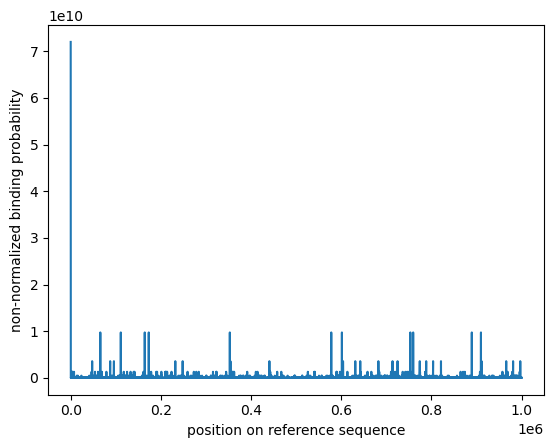

In [3]:
ref = np.random.randint(low = 0, high = 4, size = 10**6)
target = ref[:10]
energies = sc_np(ref, target)  # is the total binding energy for each position
plt.plot(np.exp(energies));    # Boltzmann factor
plt.ylabel("non-normalized binding probability")
plt.xlabel("position on reference sequence");
# As a reference there is a perfect match a the start of the sequence


 <br>

 ------

 <br>

## RNA Pumby binding

> basicly the same idea as before, but we dont know the match/missmatch energy (yet).



<div  style="display: flex;justify-content: space-between;">
    <div style="flex: 1; margin-right: 20px;">
        <p>from the pumby paper (http://www.pnas.org/cgi/doi/10.1073/pnas.1519368113) lets have a look at the binding frequency as a function of the number of mismatches.
</p>
        <p>While the distribution should be a Boltzmann distribution, it look only roughly like a exponential function. Maybe intensities measurements behave nonlinear (e.g. overexposed pixels?) to the actual binding rate.</p>
        <p>The greatest relative difference is between 2 and 1 mismatches, with a 2-3x relative increase. Therefore the energy scale is on the order of 1kT per mismatch, assuming that at higher binding rates the intensity measurement starts to get saturated, otherwise the energy per missmatch would be even lower. </p>
        
</div>
    <div style="width: 400px; padding: 10px; ">
        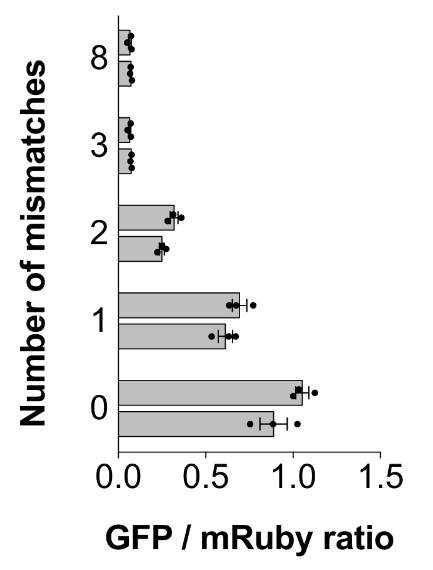
    </div>
</div>



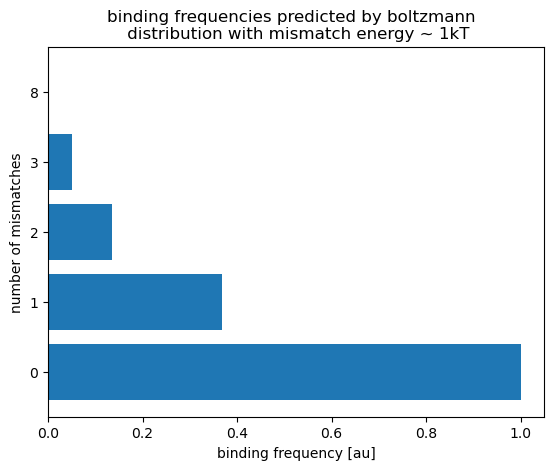

In [4]:
# theoretical binding probability i.e. Boltzmann distribution, trying to reconsitute the figure
energy = np.array([8, 3, 2, 1, 0]) # binding energy is roughly 1kt * number of mismatches
plt.barh(range(len(energy)), np.exp(-energy)) # energy scale is 1 kT
plt.yticks(range(len(energy)), energy)
plt.gca().invert_yaxis()
plt.ylabel("number of mismatches")
plt.xlabel("binding frequency [au]")  # frequency in arbitrary units because this is only the boltzman factor, whithout normalisation (e.g. partition function)
plt.title("binding frequencies predicted by boltzmann  \n distribution with mismatch energy ~ 1kT");

In [5]:
from time import time
s = time()
ref = np.random.randint(low = 0, high = 4, size = 10**7) # random 10 Mbp transcriptom 
target = np.random.randint(low = 0, high = 4, size = 12) # target sequence is 12bp long
miss_matches = (len(target) - sc_jit(ref, target))
# sc_jit is a SequenceComparison function returning the number of matches at each position -> -len(target) to get the number of mismatches. As shown in the cells above the energy per mismatch is ~1 kT 
# miss_matches is an array the number of missmatches (the predicted binding energy in kT) for each possible position
print(f"{time()-s:.3g}s")

0.087s


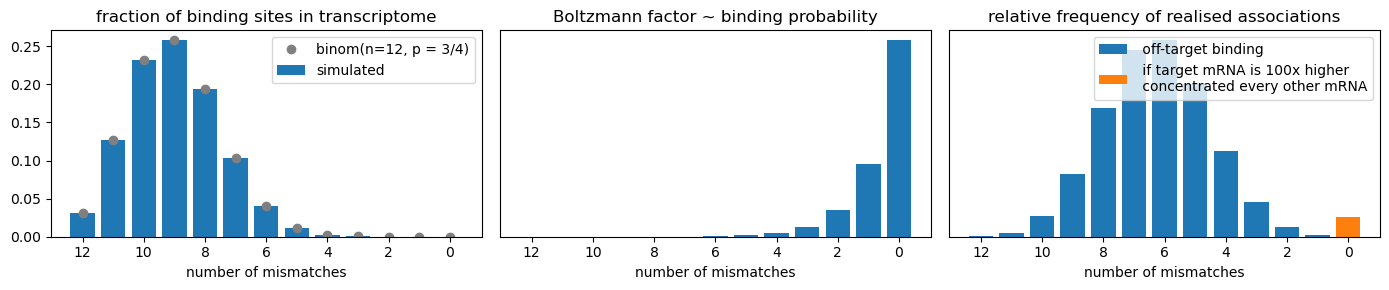

In [6]:
fig, (ax, bx, cx) = plt.subplots(1, 3, figsize = (14, 3))
mm_count, bin_edges = np.histogram(miss_matches, bins = len(target)+1, range = (-0.5, len(target)+0.5), density = True)
ax.invert_xaxis()
energies = (bin_edges[1:] + bin_edges[:-1])/2 * 1 # as said before the energy is the numebnr of missmatches in kT, using bin_edges here to get the mis match values used in plotted in the diagrams
ax.bar(energies, mm_count, label = "simulated")
ax.set_title("fraction of binding sites in transcriptome") # I guess this distribution is the binom for p=0.25 and n = 12 # Indeed it is (https://www.desmos.com/calculator/9ywaivjezz)
ax.set_xlabel("number of mismatches");
ax.plot(energies, stats.binom.pmf(energies, len(target), 3/4), label = f"binom(n={len(target)}, p = 3/4)", color = "grey", marker = "o", lw = 0)
ax.legend()

bind_freq = np.exp(-energies)
bx.bar(energies, bind_freq)
bx.invert_xaxis()
bx.set_title("Boltzmann factor ~ binding probability") # in arbitrary units since its just the boltzmann factor, without normalisation
bx.set_xlabel("number of mismatches");

cx.bar(energies, bind_freq*mm_count*len(ref), label =" off-target binding")
cx.invert_xaxis()
cx.set_title("relative frequency of realised associations")
cx.set_xlabel("number of mismatches");
cx.bar(0, bind_freq*100, zorder = -1, label =" if target mRNA is 100x higher \n concentrated every other mRNA");

# because I dont have the partitionsum, the boltzman factor alone is only proportional to the probability, but its not normalized. Therefore everything is in arbitrary units
#ax.set_yticks([])
bx.set_yticks([])
cx.set_yticks([])
cx.legend()
plt.tight_layout();

As the right panel shows it seems pumby would spend most of its time interacting with offsite targets. Although the interaction with each of them is much shorter (as the individual binding probability is much lower see center panel) the huge amount of possible off site targets (left panel) leads to a very low amount of specific target interactions. The orange bar shows assumes that the target mRNA's concentration than the concentration of all other transcripts (which I assumes is the same concentration for all of them)

> All of this is without any phase seperation, just simple binding dynamics. Also neglected is the entropic aspect of missmatches allowing the protein and RNA to gain degrees of freedom. However this entropic energy would work against the enthalpic interactions, which according to this model are already to weak for specific binding.